In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = ['hildebrand_Cuviers_beaked_whale', 'hildebrand_Gervaiss_beaked_whale']

In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [7]:
hparams = HParams(
    num_mel_bins = 64,
    mel_lower_edge_hertz=10000,
    mel_upper_edge_hertz=80000,
    butter_lowcut = 3000,
    butter_highcut = 80000,
    ref_level_db = 20,
    min_level_db = -25,
    win_length_ms = 0.25,
    hop_length_ms = .005,
    mask_spec = True,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10}
)

In [8]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

In [9]:
# dataset.data_files = {i:dataset.data_files[i] for i in list(dataset.data_files.keys())[:5]}

In [10]:
dataset.sample_json

OrderedDict([('species', 'Ziphius cavirostris'),
             ('common_name', "Cuvier's beaked whale"),
             ('site', 'DT'),
             ('recording_num', '03'),
             ('bout_i', 164),
             ('samplerate_hz', 200000),
             ('length_s', 990.0990099009902),
             ('wav_loc',
              '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/hildebrand_Cuviers_beaked_whale/2019-09-30_14-41-47/WAV/2011-08-12_13-31-20_912164.WAV'),
             ('indvs',
              OrderedDict([('UNK',
                            OrderedDict([('clicks',
                                          OrderedDict([('start_times', [0.0]),
                                                       ('end_times',
                                                        [0.00101])]))]))]))])

In [11]:
len(dataset.data_files)

4175

#### Create dataset based upon JSON

In [12]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [13]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="clicks",
            dict_features_to_retain = ['common_name'],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1912s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1968s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:    6.1s
[Parallel(n_j

[Parallel(n_jobs=-1)]: Done 4175 out of 4175 | elapsed:   12.3s finished


4175

In [14]:
syllable_df[:3]

start_time  end_time indv  indvi            common_name  \
0         0.0   0.00101  UNK      0  Cuvier's beaked whale   
0         0.0   0.00101  UNK      0  Cuvier's beaked whale   
0         0.0   0.00101  UNK      0  Cuvier's beaked whale   

                          key  
0  2011-08-12_13-31-20_912164  
0  2011-06-02_16-19-42_846126  
0  2011-08-28_12-56-42_879450

### get audio for dataset

In [15]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 4175 out of 4175 | elapsed:   43.6s finished


4175

In [16]:
df_mask  = np.array([len(i) > 0 for i in tqdm(syllable_df.audio.values)])

In [17]:
syllable_df = syllable_df[np.array(df_mask)]

In [18]:
syllable_df[:3]

start_time  end_time indv  indvi            common_name  \
0         0.0   0.00101  UNK      0  Cuvier's beaked whale   
0         0.0   0.00101  UNK      0  Cuvier's beaked whale   
0         0.0   0.00101  UNK      0  Cuvier's beaked whale   

                          key  \
0  2011-08-12_13-31-20_912164   
0  2011-06-02_16-19-42_846126   
0  2011-08-28_12-56-42_879450   

                                               audio    rate  
0  [9.17374145283552e-05, -0.002363522653123787, ...  200000  
0  [0.03042930039905542, 0.04808247260174797, -0....  200000  
0  [0.006329881602456509, 0.012236309839598329, -...  200000

In [19]:
sylls = syllable_df.audio.values

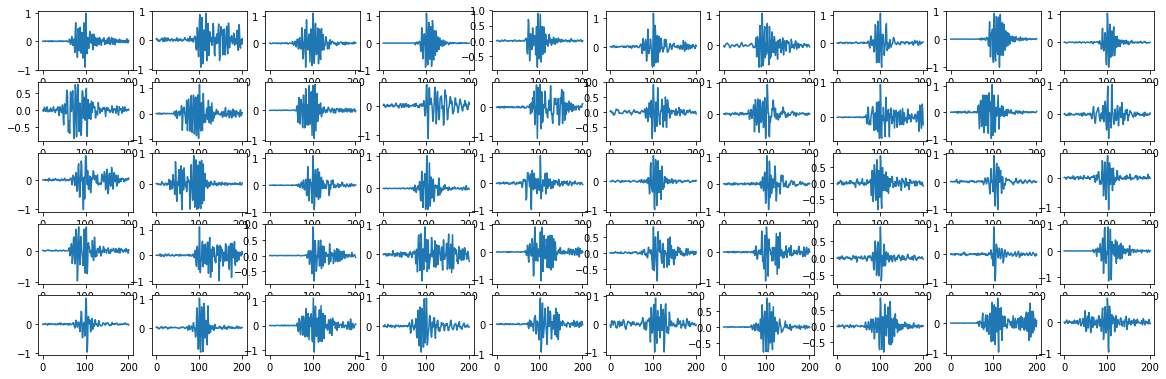

In [20]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

In [21]:
syllable_df['audio'] = [i/np.max(i) for i in syllable_df.audio.values]

### Create spectrograms

In [22]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [23]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [24]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0643s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1223s.) Setting batch_size=18.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1002 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1344 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1722 tasks      | elapsed:    1.2s
[Parallel

[Parallel(n_jobs=-1)]: Done 4175 out of 4175 | elapsed:    2.5s finished


### Rescale spectrogram
- using log rescaling

In [25]:
log_scaling_factor = 10

In [26]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0082s.) Setting batch_size=48.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1527s.) Setting batch_size=124.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    0.2s


[Parallel(n_jobs=-1)]: Done 4175 out of 4175 | elapsed:    1.2s finished


(25.0, 10) (640, 1600) 25.0 64 1600


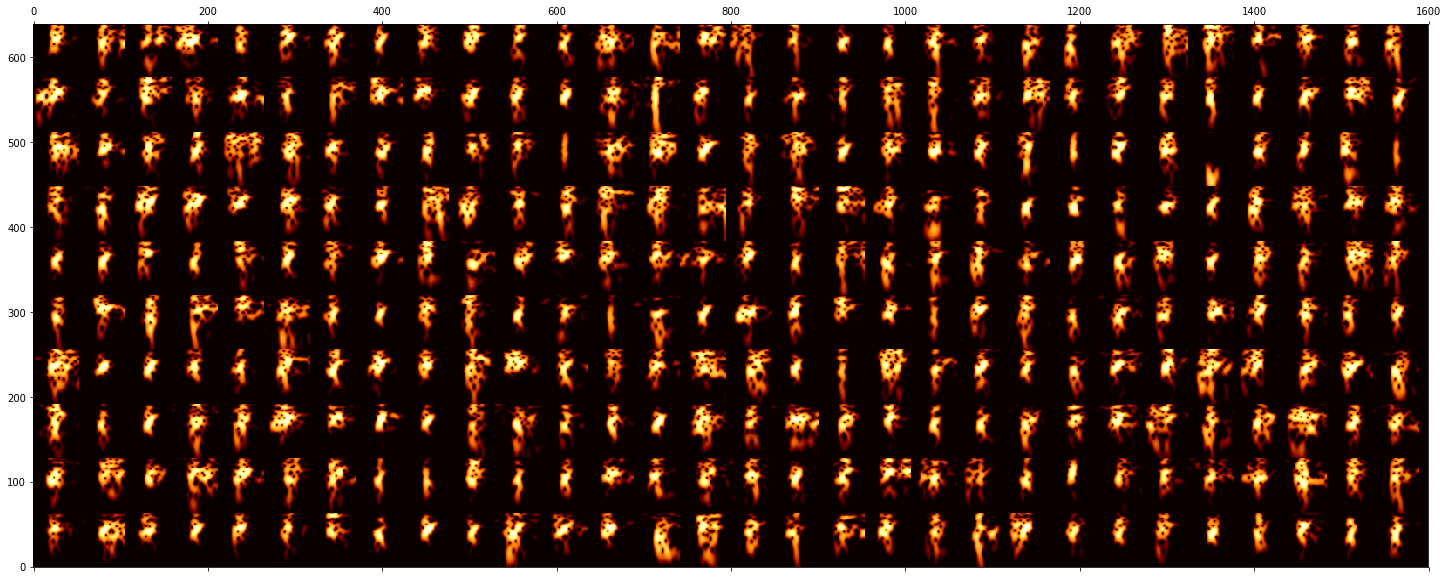

In [27]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### Pad spectrograms

In [28]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [29]:
syllable_df[:3]

start_time  end_time indv  indvi            common_name  \
0         0.0   0.00101  UNK      0  Cuvier's beaked whale   
0         0.0   0.00101  UNK      0  Cuvier's beaked whale   
0         0.0   0.00101  UNK      0  Cuvier's beaked whale   

                          key  \
0  2011-08-12_13-31-20_912164   
0  2011-06-02_16-19-42_846126   
0  2011-08-28_12-56-42_879450   

                                               audio    rate  
0  [9.378765035432023e-05, -0.0024163449268256093...  200000  
0  [0.03333022408487512, 0.05266633032486267, -0....  200000  
0  [0.00583467431446328, 0.011279023401829767, -0...  200000

In [30]:
import seaborn as sns

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return u

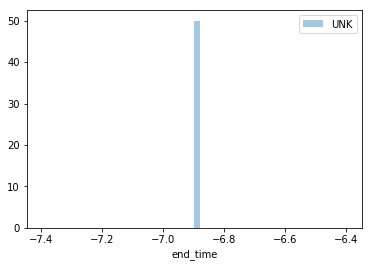

In [31]:
for indv in np.unique(syllable_df.indv):
    sns.distplot(np.log(syllable_df[syllable_df.indv==indv]["end_time"]), label=indv)
plt.legend()

In [32]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0102s.) Setting batch_size=38.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1590s.) Setting batch_size=94.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    0.3s


[Parallel(n_jobs=-1)]: Done 4175 out of 4175 | elapsed:    0.6s finished


(25.0, 10) (640, 1600) 25.0 64 1600


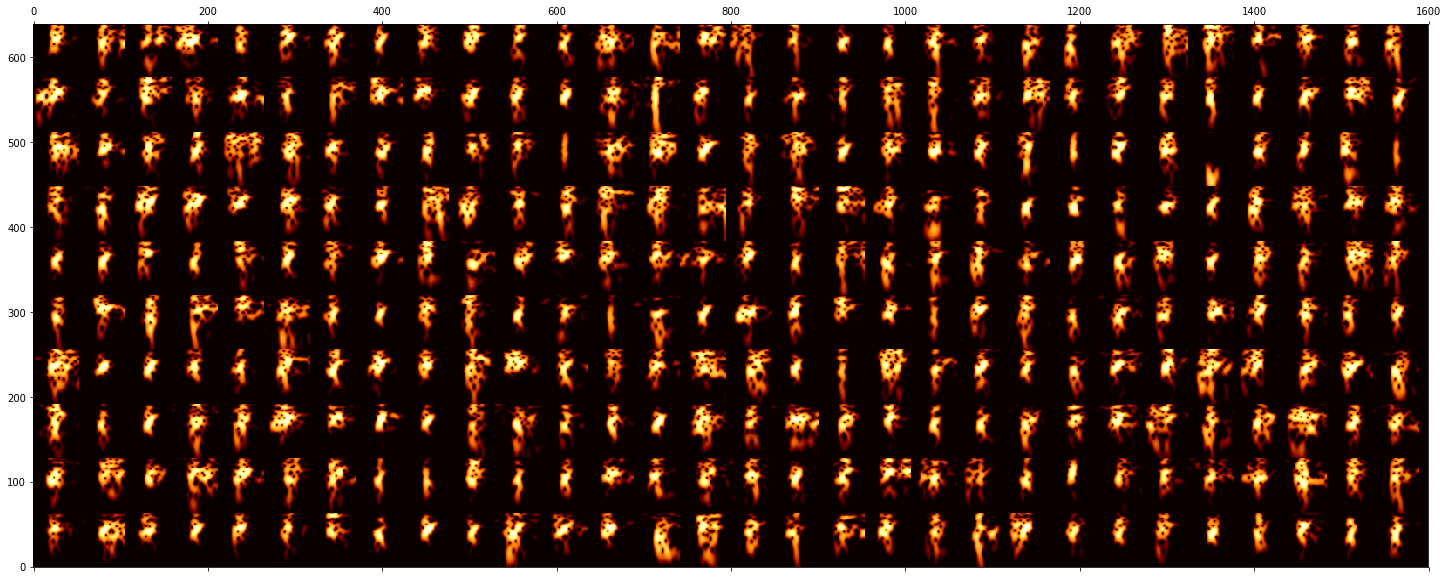

In [33]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [34]:
np.shape(syllables_spec)

(4175, 64, 53)

In [35]:
syllable_df['spectrogram'] = syllables_spec

In [36]:
syllable_df[:3]

start_time  end_time indv  indvi            common_name  \
0         0.0   0.00101  UNK      0  Cuvier's beaked whale   
0         0.0   0.00101  UNK      0  Cuvier's beaked whale   
0         0.0   0.00101  UNK      0  Cuvier's beaked whale   

                          key  \
0  2011-08-12_13-31-20_912164   
0  2011-06-02_16-19-42_846126   
0  2011-08-28_12-56-42_879450   

                                               audio    rate  \
0  [9.378765035432023e-05, -0.0024163449268256093...  200000   
0  [0.03333022408487512, 0.05266633032486267, -0....  200000   
0  [0.00583467431446328, 0.011279023401829767, -0...  200000   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

### view syllables per indv

In [37]:
syllable_df.indv.unique()

array(['UNK'], dtype=object)

UNK 2238
(50.0, 32) (1024, 1600) 25.0 64 1600


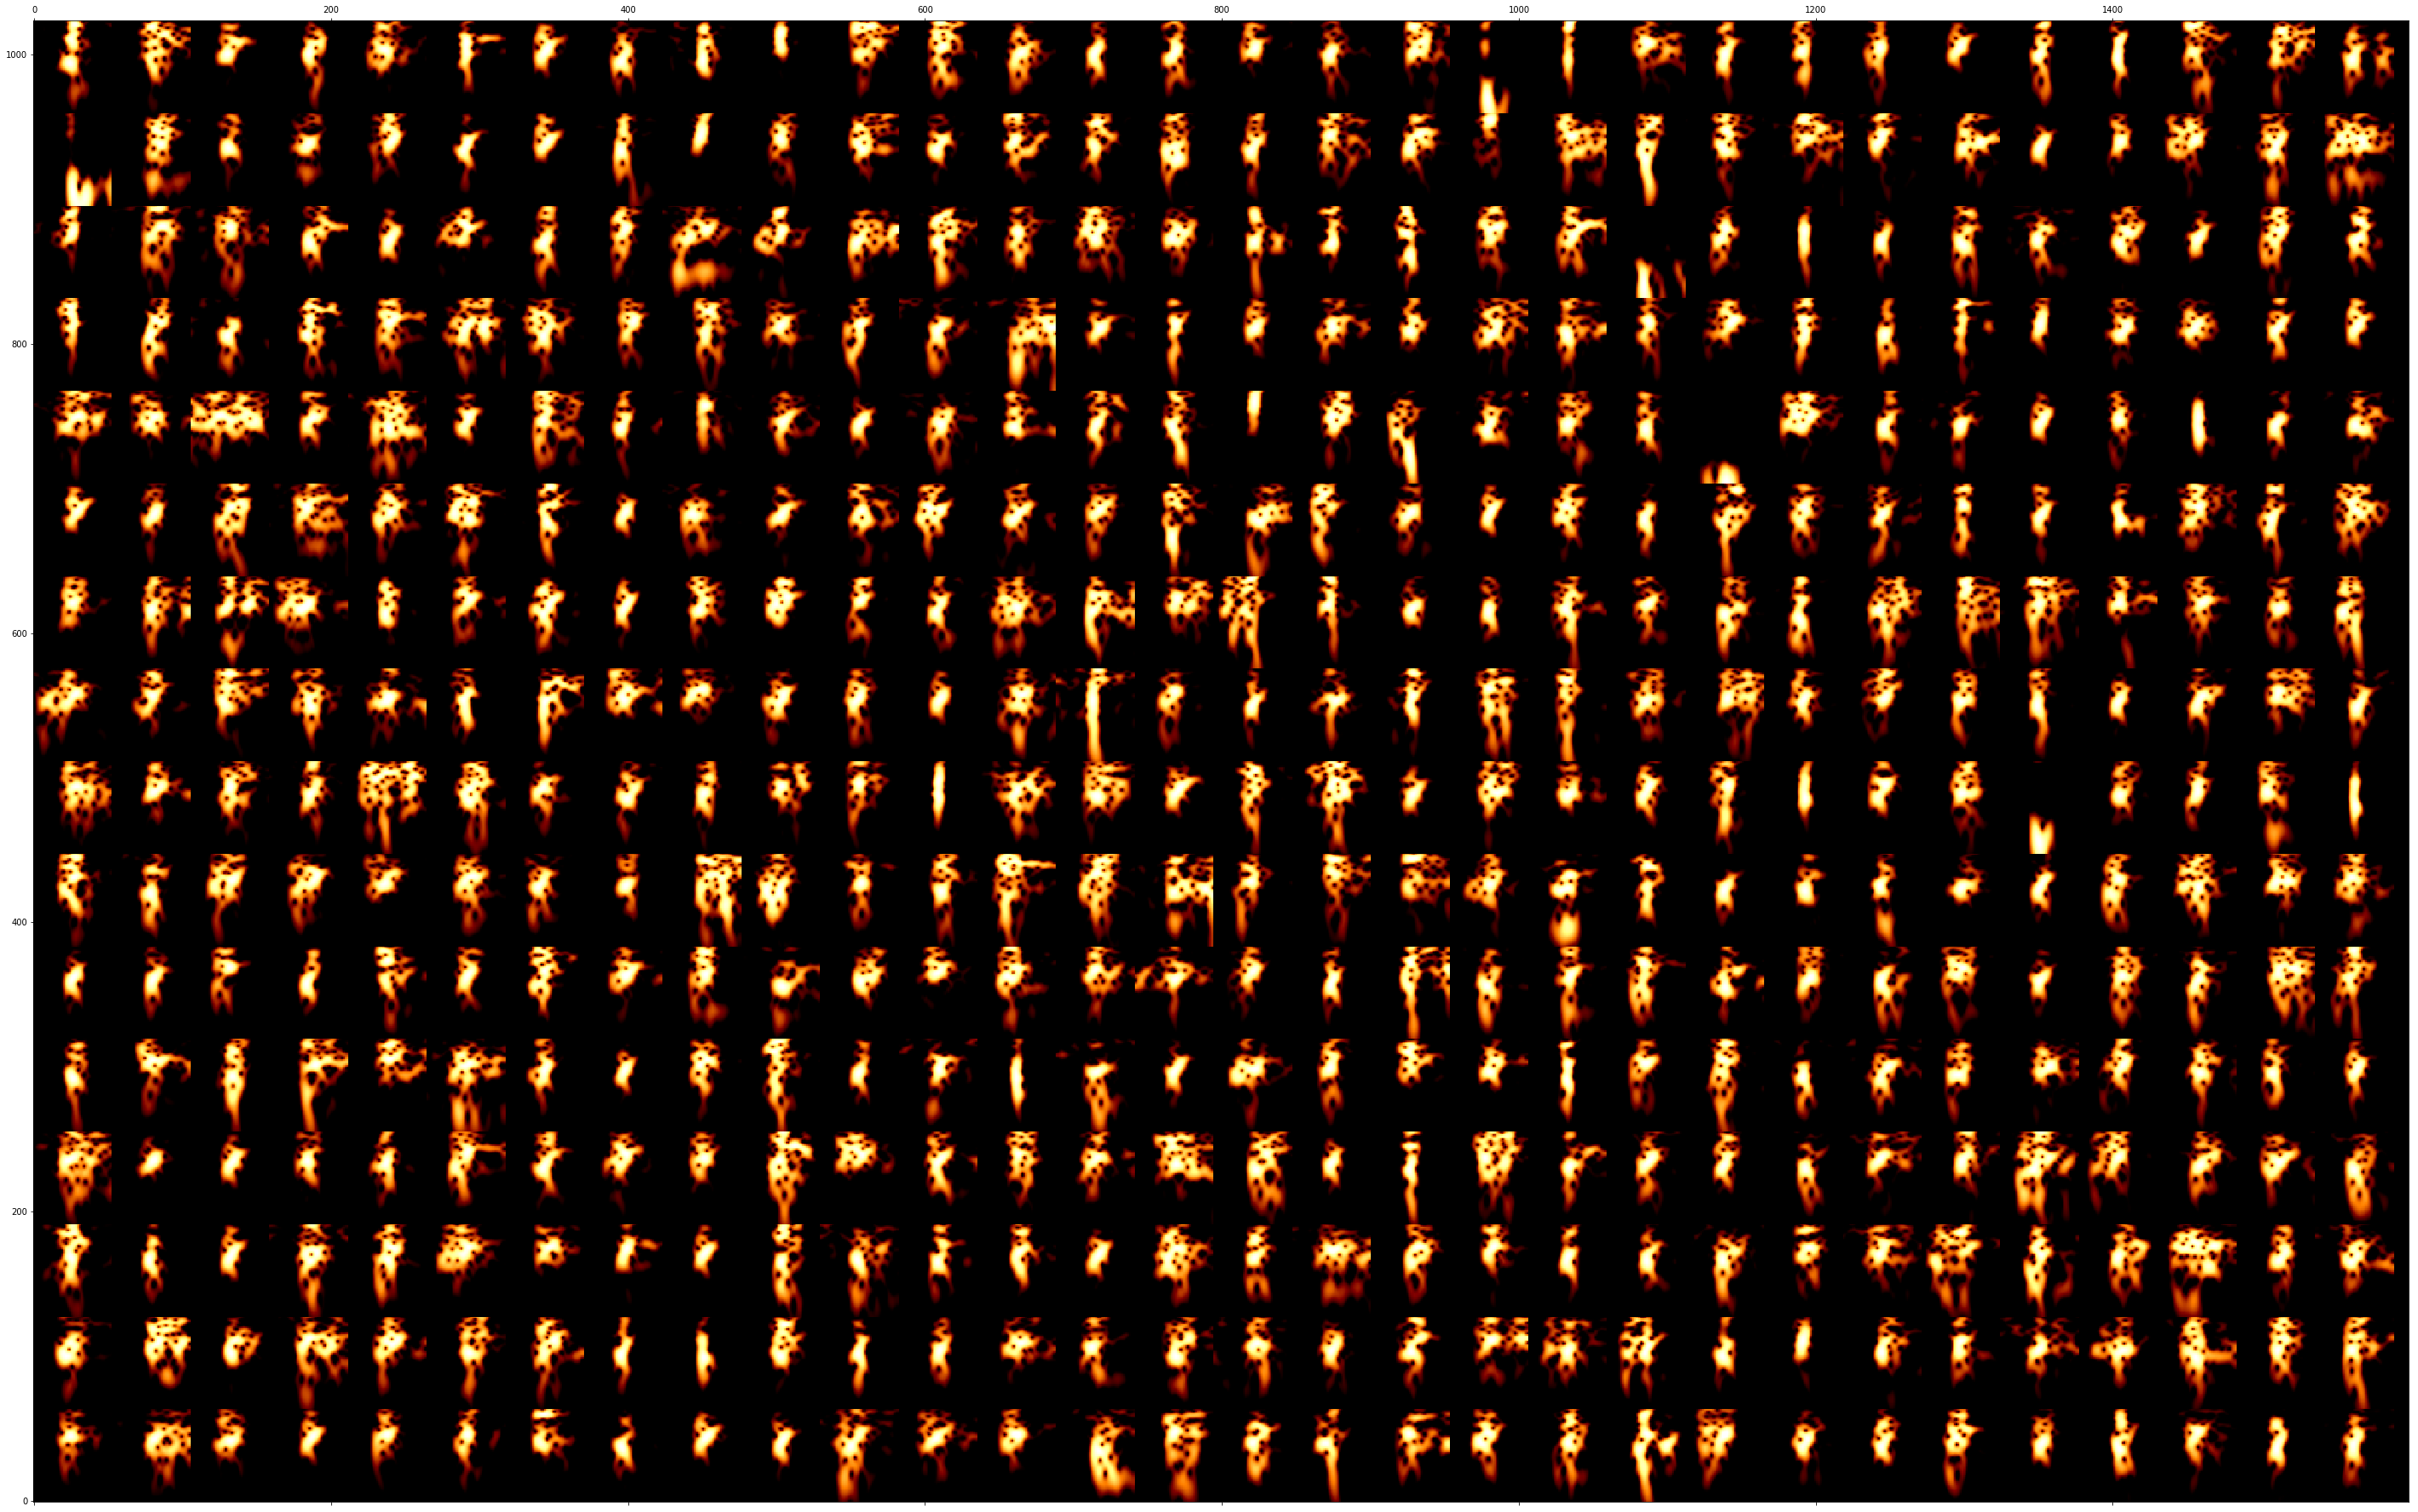

UNK 1937
(50.0, 32) (1024, 1600) 25.0 64 1600


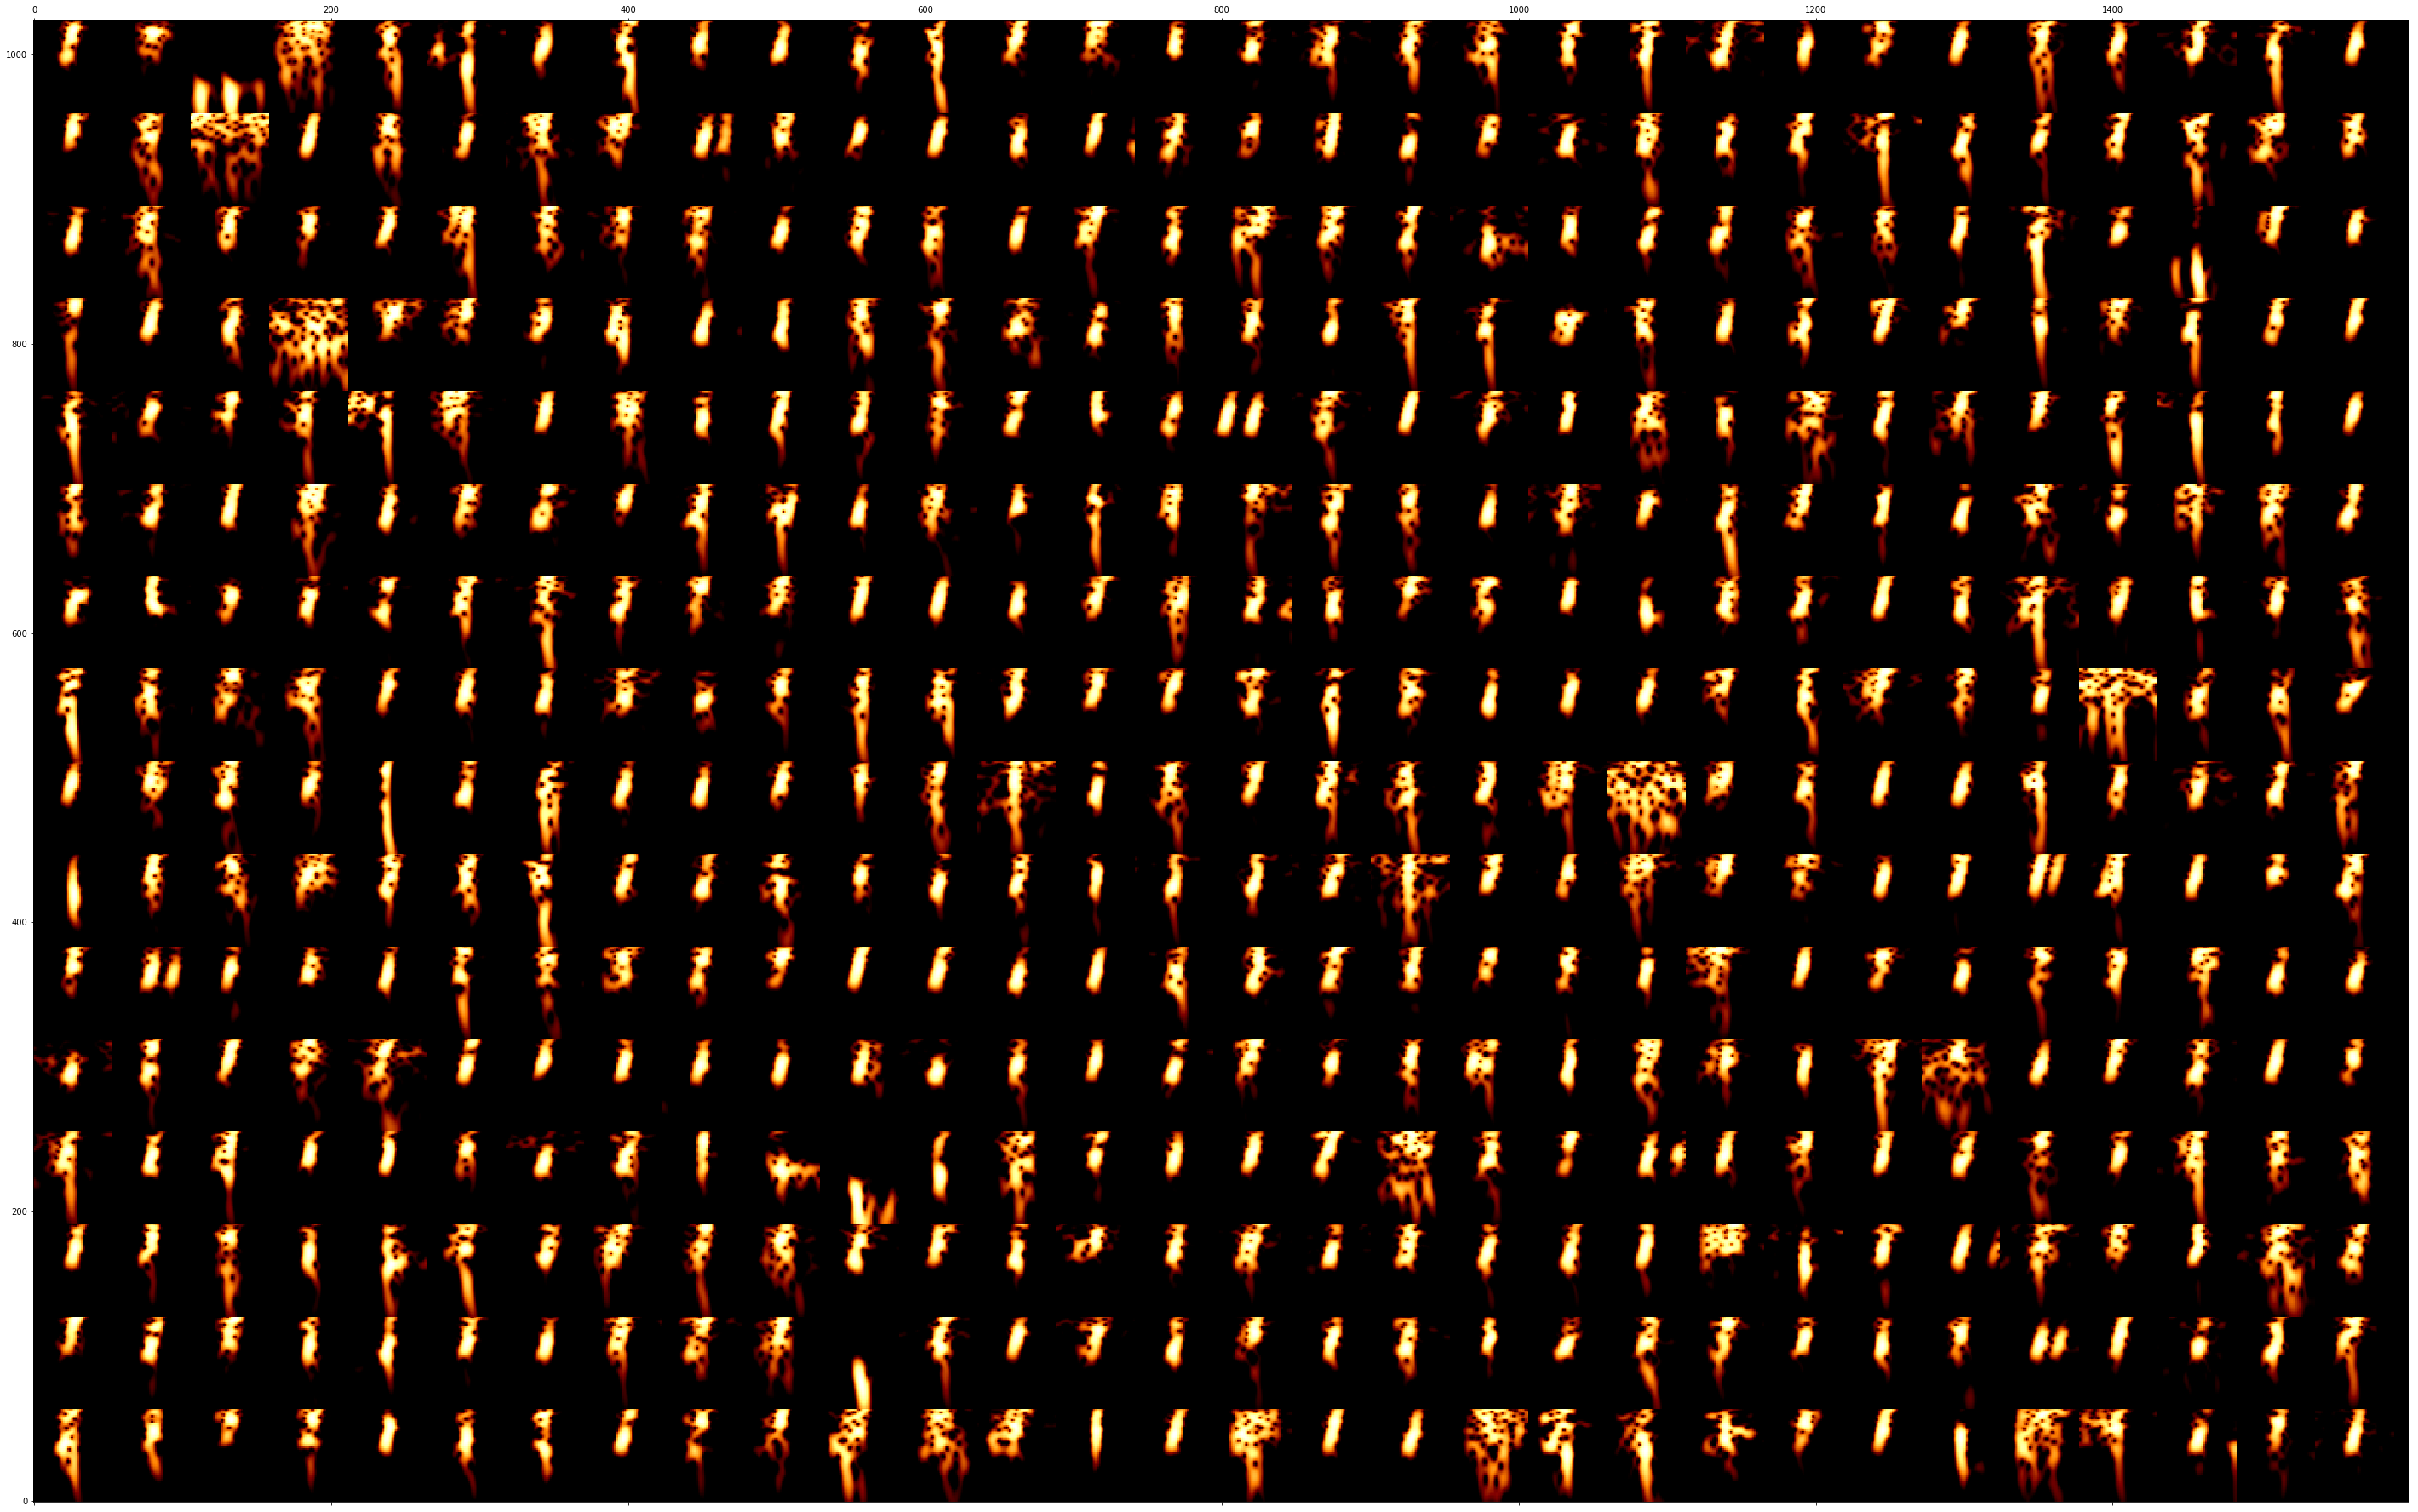

In [38]:
for common_name in np.sort(syllable_df.common_name.unique()):
    print(indv, np.sum(syllable_df.common_name == common_name))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.common_name == common_name].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

### save dataset

In [39]:
save_loc = DATA_DIR / 'syllable_dfs' / 'hildebrand' / 'beaked_whale.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)